## Creating Connection

In [91]:
# Define Neo4j connections

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import plotly.graph_objects as go

In [2]:
# Create Neo4j Connection

host = 'bolt://34.234.223.89:7687'
user = 'neo4j'
password = 'coils-shocks-gages'
driver = GraphDatabase.driver(host, auth=(user, password))

## Adding Data - (dont run this)

In [3]:
import_queries = """

CALL apoc.schema.assert({Character:['name']},{Comic:['id'], Character:['id'], Event:['id'], Group:['id']});

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroes.csv" as row
CREATE (c:Character)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/groups.csv" as row
CREATE (c:Group)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/events.csv" as row
CREATE (c:Event)
SET c += row;

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/comics.csv" as row
CREATE (c:Comic)
SET c += apoc.map.clean(row,[],["null"]);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToComics.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (co:Comic{id:row.comic})
MERGE (c)-[:APPEARED_IN]->(co);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToEvent.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (e:Event{id:row.event})
MERGE (c)-[:PART_OF_EVENT]->(e);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToGroup.csv" as row
MATCH (c:Character{id:row.hero})
MATCH (g:Group{id:row.group})
MERGE (c)-[:PART_OF_GROUP]->(g);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroToHero.csv" as row
MATCH (s:Character{id:row.source})
MATCH (t:Character{id:row.target})
CALL apoc.create.relationship(s,row.type, {}, t) YIELD rel
RETURN distinct 'done';

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroStats.csv" as row
MATCH (s:Character{id:row.hero})
CREATE (s)-[:HAS_STATS]->(stats:Stats)
SET stats += apoc.map.clean(row,['hero'],[]);

LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/rrsr28/marvel-bigdataProject/main/data/marvel_scraped/heroFlight.csv" as row
MATCH (s:Character{id:row.hero})
SET s.flight = row.flight;

MATCH (s:Stats)
WITH keys(s) as keys LIMIT 1
MATCH (s:Stats)
UNWIND keys as key
CALL apoc.create.setProperty(s, key, toInteger(s[key]))
YIELD node
RETURN distinct 'done';
"""

In [ ]:
"""
# Establish a session with the Neo4j database using the provided driver
# Split the import_queries string into individual statements using ';' as the delimiter
# Execute each statement within the session context after stripping leading and trailing whitespace

with driver.session() as session:
    for statement in import_queries.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass
"""

## Run Query

In [44]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [80]:
def run_query_with_params(query, params):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

## Exploratory graph analysis

In [5]:
# Nummber of comic appearances 

run_query("""
            MATCH (c:Character)
            RETURN c.name as character, 
                   count{ (c)-[:APPEARED_IN]->() } as comics
            ORDER BY comics DESC
            LIMIT 10
                        """)

character  comics
0                 Spider-Man (1602)    3357
1                        Tony Stark    2354
2                             Logan    2098
3                      Steve Rogers    2019
4  Thor (Marvel: Avengers Alliance)    1547
5                          Hulk-dok    1433
6                      Johnny Storm    1151
7                   Matthew Murdock     999
8                           Cyclops     851
9             Thing (Marvel Heroes)     842

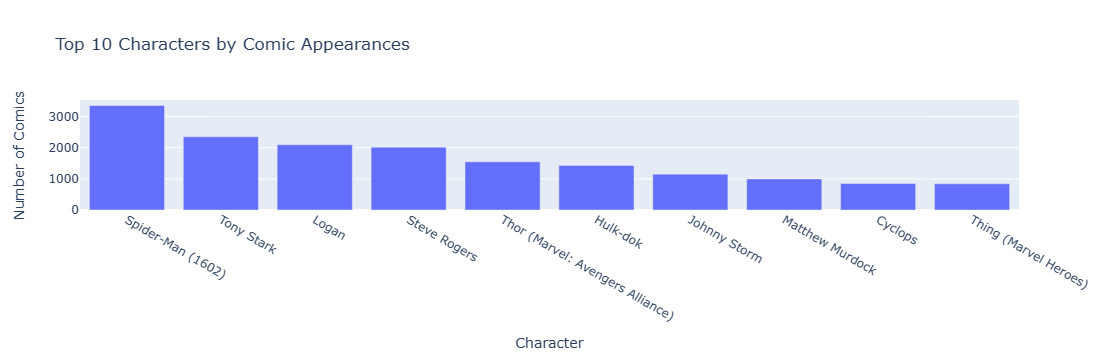

In [6]:
# Call the 'run_query' function with the Cypher query
result_df = run_query("""
                        MATCH (c:Character)
                        RETURN c.name as character, 
                               count{ (c)-[:APPEARED_IN]->() } as comics
                        ORDER BY comics DESC
                        LIMIT 10
                                    """)

fig = px.bar(result_df, x='character', y='comics', title='Top 10 Characters by Comic Appearances')
fig.update_layout(xaxis_title='Character', yaxis_title='Number of Comics')
fig.show()

In [7]:
# Comic releases through the years

run_query("""
                MATCH (c:Comic)
                RETURN substring(c.year, 0, 3) + "0" as decade, 
                       count(*) as count
                ORDER BY decade ASC
                                        """)

decade  count
0    1930     95
1    1940    584
2    1950    756
3    1960   4114
4    1970   1956
5    1980   2428
6    1990   3738
7    2000   8309
8    2010  11139
9    2020     19
10   None   5737

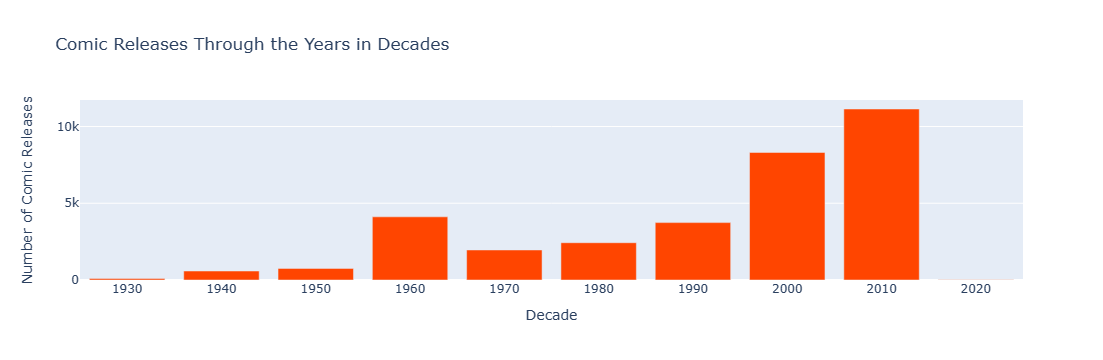

In [11]:
result_df = run_query("""
                MATCH (c:Comic)
                RETURN substring(c.year, 0, 3) + "0" as decade, 
                       count(*) as count
                ORDER BY decade ASC
                                        """)

fig = px.bar(result_df, x='decade', y='count', title='Comic Releases Through the Years in Decades')
fig.update_layout(xaxis_title='Decade', yaxis_title='Number of Comic Releases')
fig.update_traces(marker_color='orangered')
fig.show()

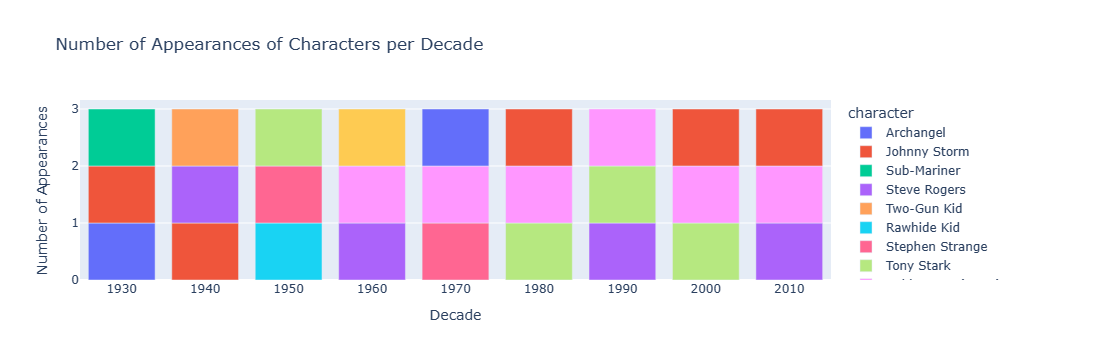

In [24]:
# Top three famous characters through the years

result_df = run_query("""
                            MATCH (c:Comic)<-[:APPEARED_IN]-(c1:Character)
                            WHERE NOT c.year = "null"
                            WITH substring(c.year,0,3) + "0" as decade, 
                                 c1.name as character, 
                                 count(*) as count
                            ORDER BY count DESC
                            RETURN decade, collect(character)[..3] as top_3_characters
                            ORDER BY decade
                                                """)

# Flatten the list of top 3 characters and create a new DataFrame
character_df = pd.DataFrame([(decade, character) for decade, characters in zip(result_df['decade'], result_df['top_3_characters']) for character in characters], columns=['decade', 'character'])

# Count the number of appearances for each character
character_counts = character_df.groupby(['decade', 'character']).size().reset_index(name='num_appearances')



# Plotting
fig = px.bar(character_counts, x='decade', y='num_appearances', color='character',
             title='Number of Appearances of Characters per Decade',
             labels={'num_appearances': 'Number of Appearances', 'decade': 'Decade'},
             category_orders={'decade': ['1930', '1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010']})
fig.show()

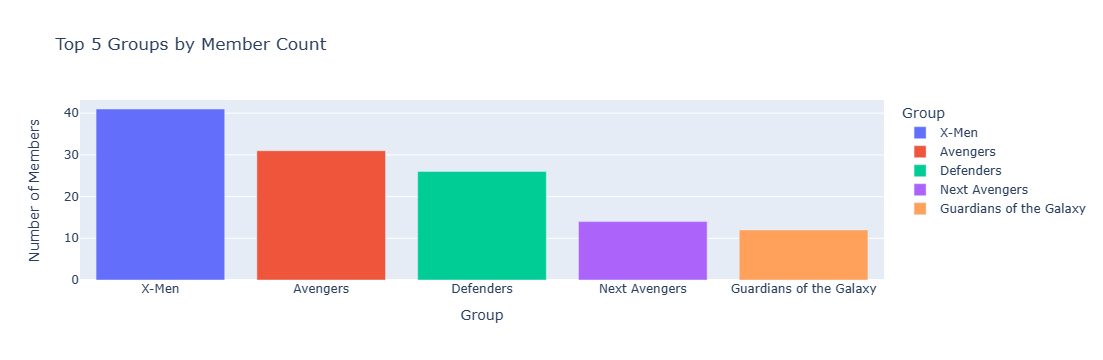

In [31]:
# Biggest groups of characters.

result_df = run_query("""
                        MATCH (g:Group)
                        RETURN g.name as group, 
                               count{ (g)<-[:PART_OF_GROUP]-() } as members
                        ORDER BY members DESC LIMIT 5
                                                """)

fig = px.bar(result_df, x='group', y='members', 
             title='Top 5 Groups by Member Count',
             labels={'members': 'Number of Members', 'group': 'Group'},
             color='group')
fig.show()

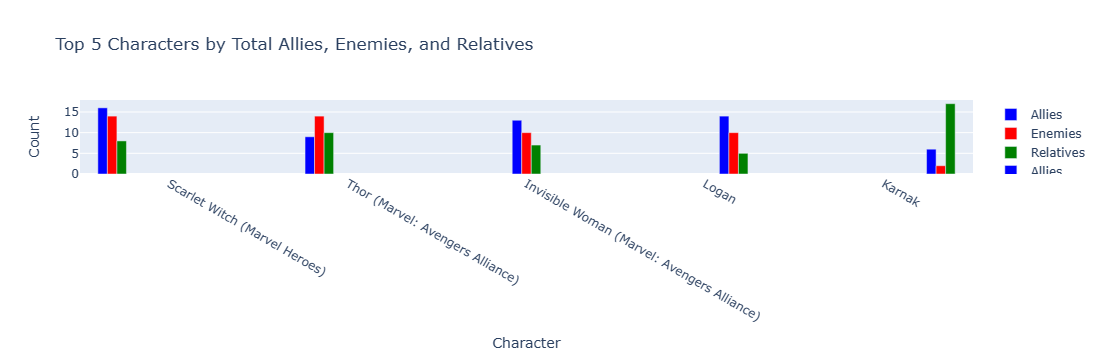

In [81]:
# Degree for each relationship type

result_df = run_query("""
            MATCH (c:Character)
            RETURN c.name as name,
                   count{ (c)-[:ALLY]->() } as allies,
                   count{ (c)-[:ENEMY]->() } as enemies,
                   count{ (c)-[:RELATIVE]->() } as relative
            ORDER BY allies + enemies + relative DESC LIMIT 5 
                                                                """)

fig = go.Figure()

# Add bars for allies, enemies, and relatives for each character
for index, row in result_df.iterrows():
    character = row['name']
    allies = row['allies']
    enemies = row['enemies']
    relatives = row['relative']
    
    fig.add_trace(go.Bar(
        x=[character],
        y=[allies],
        name='Allies',
        marker_color='blue'
    ))
    
    fig.add_trace(go.Bar(
        x=[character],
        y=[enemies],
        name='Enemies',
        marker_color='red'
    ))
    
    fig.add_trace(go.Bar(
        x=[character],
        y=[relatives],
        name='Relatives',
        marker_color='green'
    ))

# Update layout
fig.update_layout(barmode='group',
                  title='Top 5 Characters by Total Allies, Enemies, and Relatives',
                  xaxis_title='Character',
                  yaxis_title='Count')

# Show the plot
fig.show()

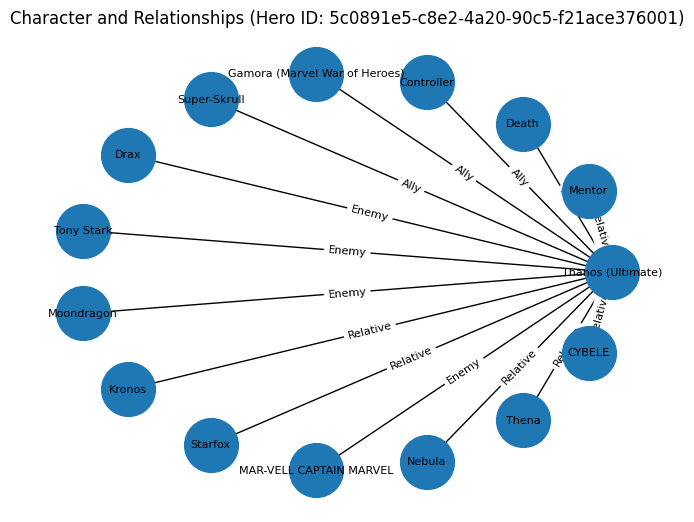

In [113]:
# Define the query with parameters
query = """
MATCH (c:Character {id: $hero_id})
OPTIONAL MATCH (c)-[:ALLY]->(ally)
OPTIONAL MATCH (c)-[:ENEMY]->(enemy)
OPTIONAL MATCH (c)-[:RELATIVE]->(relative)
RETURN c.name as character,
       collect(DISTINCT ally.name) as allies,
       collect(DISTINCT enemy.name) as enemies,
       collect(DISTINCT relative.name) as relatives
"""

# Define the hero ID
hero_id = "5c0891e5-c8e2-4a20-90c5-f21ace376001"

# Execute the query with parameters
result = run_query_with_params(query, {"hero_id": hero_id})

# Check if there's any data
if not result.empty:
    # Extract data from the result
    character_name = result['character'][0]
    allies = result['allies'][0]
    enemies = result['enemies'][0]
    relatives = result['relatives'][0]

    # Create a networkx graph
    G = nx.Graph()

    # Add character node
    G.add_node(character_name, label=character_name, type='Character')

    # Add nodes for allies, enemies, and relatives
    for ally in allies:
        G.add_node(ally, label=ally, type='Ally')
        G.add_edge(character_name, ally, relationship='Ally')

    for enemy in enemies:
        G.add_node(enemy, label=enemy, type='Enemy')
        G.add_edge(character_name, enemy, relationship='Enemy')

    for relative in relatives:
        G.add_node(relative, label=relative, type='Relative')
        G.add_edge(character_name, relative, relationship='Relative')

    # Draw the graph with customizations
    pos = nx.circular_layout(G)  # Change the layout to circular
    nx.draw(G, pos, with_labels=True, node_size=1500, font_size=8)  # Adjust node size and font size
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)  # Adjust edge label font size
    plt.title(f"Character and Relationships (Hero ID: {hero_id})")
    plt.axis('off')  # Remove plot axis
    plt.show()
else:
    print("No data found.")

Degree Centrality:
Thanos (Ultimate): 1.0
Mentor: 0.07142857142857142
Death: 0.07142857142857142
Controller: 0.07142857142857142
Gamora (Marvel War of Heroes): 0.07142857142857142

Closeness Centrality:
Thanos (Ultimate): 1.0
Mentor: 0.5185185185185185
Death: 0.5185185185185185
Controller: 0.5185185185185185
Gamora (Marvel War of Heroes): 0.5185185185185185

Betweenness Centrality:
Thanos (Ultimate): 1.0
Mentor: 0.0
Death: 0.0
Controller: 0.0
Gamora (Marvel War of Heroes): 0.0


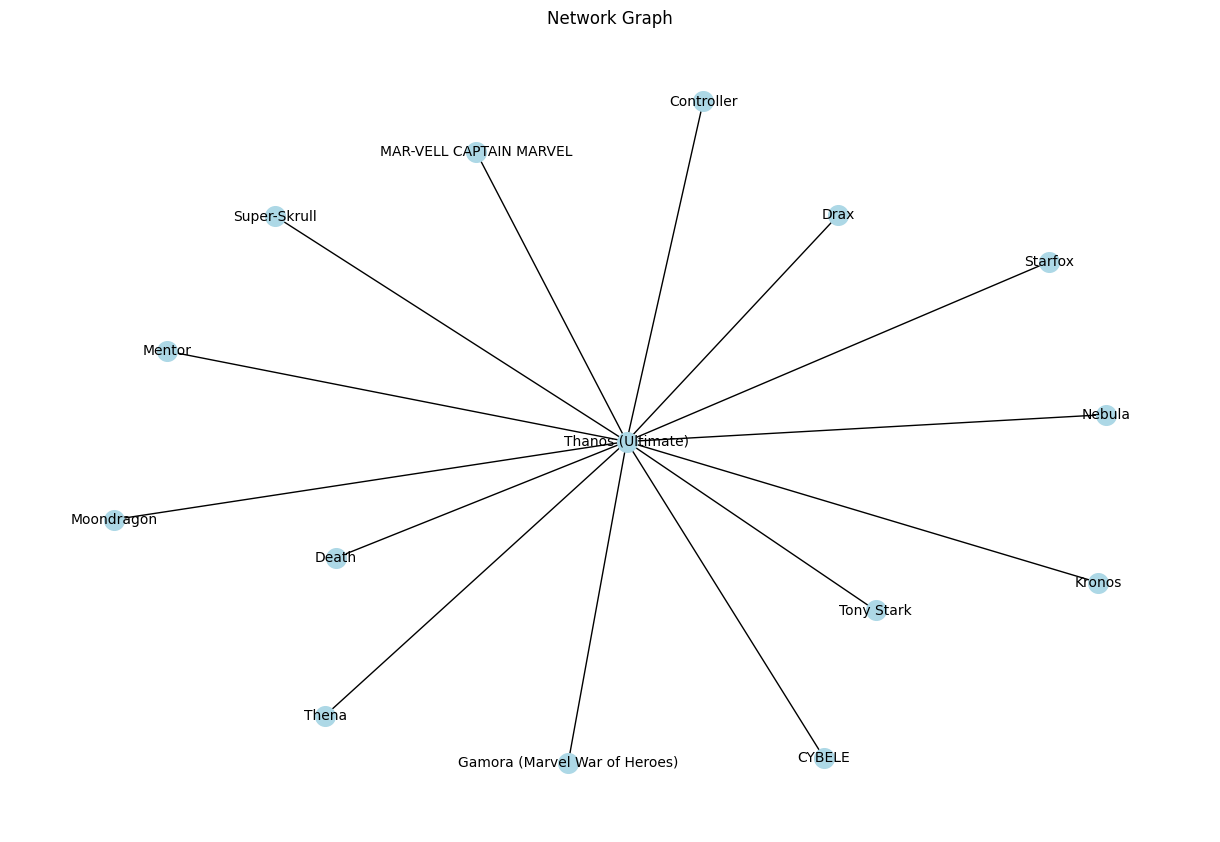

In [115]:
# Define a function to retrieve character data from Neo4j
def get_character_data_from_neo4j():
    with driver.session() as session:
        result = session.run("MATCH (c:Character) RETURN c.id as id, c.name as name, c.aliases as aliases, c.identity as identity")
        character_data = [(record["id"], record["name"], record["aliases"], record["identity"]) for record in result]
    return character_data

# Retrieve character data from Neo4j
character_data = get_character_data_from_neo4j()

# Create a NetworkX graph and add nodes for characters
# G = nx.Graph()
# for character_id, character_name, aliases, identity in character_data:
#    G.add_node(character_id, name=character_name, aliases=aliases, identity=identity, type='Character')

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print the centrality measures for the first 5 nodes
print("Degree Centrality:")
for node, centrality in list(degree_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nCloseness Centrality:")
for node, centrality in list(closeness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in list(betweenness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=10)
plt.title("Network Graph")
plt.show()

Degree Centrality:
423a200d-9ffc-4f74-a748-3be4e771c346: 0.0
5f4e3b38-f4b5-45e5-adcb-03347afbfe49: 0.0
2ae21c6e-d551-4746-9ce9-32daada7d32f: 0.0
1c02ce63-41d9-4e6e-974e-dd2a5fa1183f: 0.0
67328fa7-4fc4-477f-bfc9-a556b41c9cbb: 0.0

Closeness Centrality:
423a200d-9ffc-4f74-a748-3be4e771c346: 0.0
5f4e3b38-f4b5-45e5-adcb-03347afbfe49: 0.0
2ae21c6e-d551-4746-9ce9-32daada7d32f: 0.0
1c02ce63-41d9-4e6e-974e-dd2a5fa1183f: 0.0
67328fa7-4fc4-477f-bfc9-a556b41c9cbb: 0.0

Betweenness Centrality:
423a200d-9ffc-4f74-a748-3be4e771c346: 0.0
5f4e3b38-f4b5-45e5-adcb-03347afbfe49: 0.0
2ae21c6e-d551-4746-9ce9-32daada7d32f: 0.0
1c02ce63-41d9-4e6e-974e-dd2a5fa1183f: 0.0
67328fa7-4fc4-477f-bfc9-a556b41c9cbb: 0.0


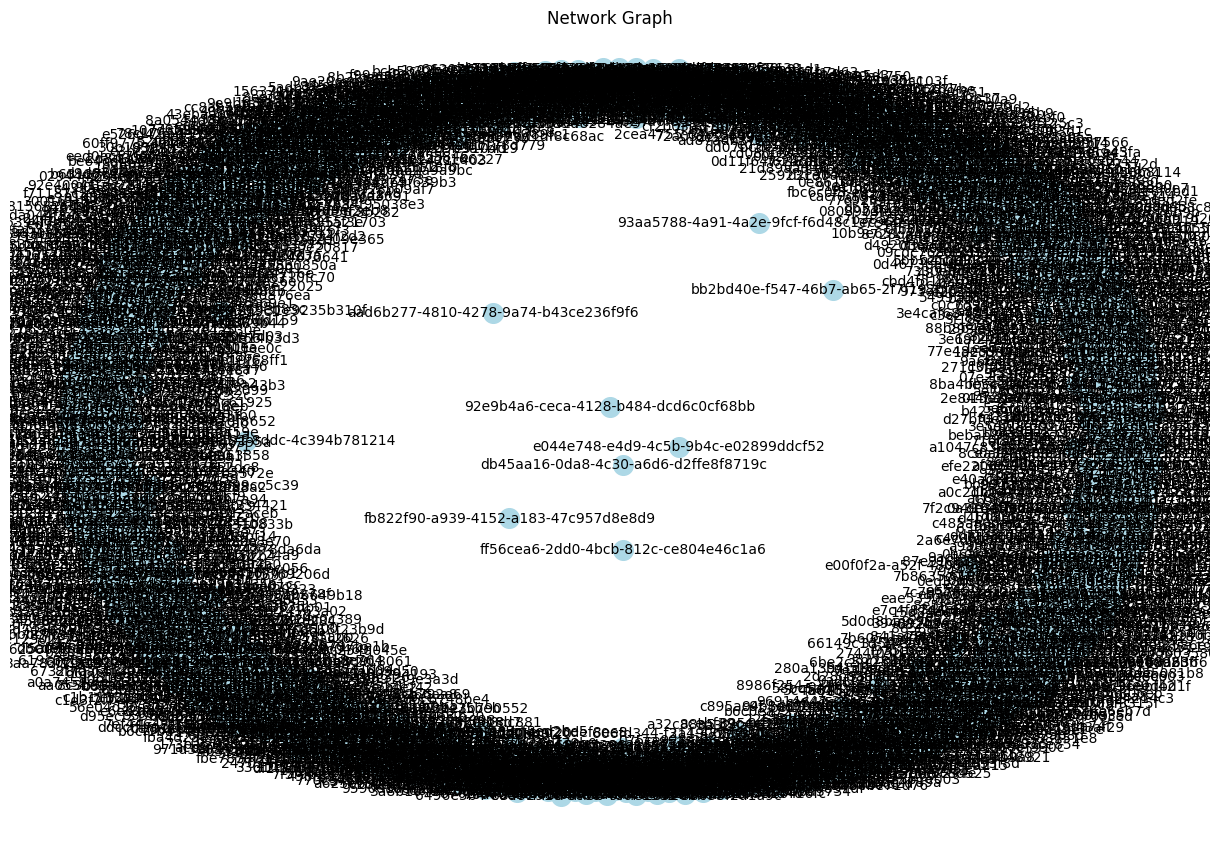

In [116]:
# Define a function to retrieve character data from Neo4j
def get_character_data_from_neo4j():
    with driver.session() as session:
        result = session.run("MATCH (c:Character) RETURN c.id as id, c.name as name, c.aliases as aliases, c.identity as identity")
        character_data = [(record["id"], record["name"], record["aliases"], record["identity"]) for record in result]
    return character_data

# Retrieve character data from Neo4j
character_data = get_character_data_from_neo4j()

# Create a NetworkX graph and add nodes for characters
G = nx.Graph()
for character_id, character_name, aliases, identity in character_data:
   G.add_node(character_id, name=character_name, aliases=aliases, identity=identity, type='Character')

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print the centrality measures for the first 5 nodes
print("Degree Centrality:")
for node, centrality in list(degree_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nCloseness Centrality:")
for node, centrality in list(closeness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in list(betweenness_centrality.items())[:5]:
    print(f"{node}: {centrality}")

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=10)
plt.title("Network Graph")
plt.show()